# Triathlon Archetypes: From Specialists to Generalists

This notebook explores triathlon race data to uncover athlete archetypes – 
such as swim specialists, strong cyclists, fast runners, and all-round “generalists”.

We will:

- Build clusters of athletes based on their swim, bike, and run performance.
- Show that generalists tend to be more successful overall.
- Analyze how athletes become more balanced as they get faster.

## Table of Contents

1. [Introduction & Goals](#introduction)
2. [Setup & Configuration](#setup)
3. [Data Loading & Basic Cleaning](#data-loading)
4. [Feature Engineering for Clustering](#feature-engineering)
5. [Choosing the Number of Clusters](#choose-k)
6. [Fitting K-Means & Defining Archetypes](#fit-kmeans)
7. [Are Generalists Actually Faster?](#generalists-faster)
8. [How Better Athletes Become More “Generalist”](#progression-generalist)


## 1. Introduction & Goals <a id="introduction"></a>

The goal of this notebook is to understand what kind of triathletes tend to perform best.

We focus on three main questions:

1. Can we discover natural archetypes of athletes based on their swim, bike, and run splits?
2. Are generalists (balanced across all three) more successful than specialists?
3. As athletes get faster, do they tend to become more balanced across disciplines?


## 2. Setup & Configuration <a id="setup"></a>

In this section we:

- Import all Python libraries needed in the notebook.
- Define project paths (e.g. where the CSV files live).
- Implement a few small helper functions used throughout
  (for clustering diagnostics, plotting, etc.).

Keeping imports and configuration in one place makes the notebook
easier to reuse and debug.


In [1]:
# setup and config

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import pi



# just based on my structure and may be adjusted if needed

HOME = Path.home()
DATA_DIR = HOME / "coachcox_results_csv"

# Optional: directory for saving figures / outputs
OUTPUT_DIR = HOME / "triathlon_outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"HOME       : {HOME}")
print(f"DATA_DIR   : {DATA_DIR}")
print(f"OUTPUT_DIR : {OUTPUT_DIR}")

# global settings for choosing correct clustering size
RANDOM_STATE = 42
DEFAULT_K_RANGE = range(2, 9)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

warnings.filterwarnings("ignore", category=FutureWarning)

# unifying columns names for convenience
SWIM_COL = "swim_time"
BIKE_COL = "bike_time"
RUN_COL = "run_time"
OVERALL_COL = "overall_time"

LEG_TIME_COLS = [SWIM_COL, BIKE_COL, RUN_COL]


HOME       : C:\Users\JanBusse
DATA_DIR   : C:\Users\JanBusse\coachcox_results_csv
OUTPUT_DIR : C:\Users\JanBusse\triathlon_outputs


In [2]:
### now create function to read in files

def load_results(path: Path) -> pd.DataFrame: ### function returns data frame
    df = pd.read_csv(path)

    ### get only stem

    base = path.stem

    ### split data accordingly since they have always names like ironman70.3aix-en-provence2011__1181
    # the last 4 digits represent the file number from my scraping job(we can safely cut that)
    # the last 4 digits before the underscore represent the year
    # otherwise, I would keep it simple as is because the race name and location are not always clear

    race_year = base.split("__")[0]

    ### last 4 characters are always race year

    year = int(race_year[-4:])
    race = race_year[:-4]

    df["race"] = race
    df["year"] = year

    # create unique id (file name)
    df["event_id"] = base
    # now extract if race was 70.3 or full distance
    stem_lower = base.lower()
    if "70.3" in stem_lower or "70_3" in stem_lower:
        df["distance"] = "70.3"
    else:
        df["distance"] = "full-distance"
    return df


In [3]:
### now calculate percentile per race


def add_relative_strength(df):
    df = df.copy()
    group_cols = ["race", "year", "gender", "event_id"] ## actually, gender and event_id should be enough

    ### overall percetile
    df["overall_rel"] = (
        df.groupby(group_cols)["Overall Time (s)"]
        .rank(method="average", pct = True, ascending = True)
    )

    ### lowest time is best

    df["overall_rel"] = 1 - df["overall_rel"]

    for col, new_col in [
        ("Swim Time (s)", "swim_rel"),
        ("Bike Time (s)", "bike_rel"),
        ("Run Time (s)", "run_rel"),
    ]:
        perc = (
            df.groupby(group_cols)[col]
            .rank(method="average", pct = True, ascending = True)
        )
        df[new_col] = 1 - perc
    
    return df

In [4]:
### now we create a helper function so we dont have to copy paste the entire code for each subset

def cluster_diagnostics(
        X,
        k_range = DEFAULT_K_RANGE,
        random_state = RANDOM_STATE,
        title_suffix="",
):
    # this is obviously an optionated choice and may be adjusted if needed
    # however, we only have 2M data points in total and silhoutte score scales with ~ O(n^2)
    X_sample = X.sample(50000, random_state=random_state)

    inertias = []
    sil_scores = []

    # here we are fitting k-means on the sample we use for each k in the range
    for k in k_range:
        km = KMeans(
            n_clusters = k,
            random_state = random_state,
            n_init="auto"
        )
        labels = km.fit_predict(X_sample)
        inertias.append(km.inertia_) # fill empty array

        # now approximate silhouette

        sil_score = silhouette_score(
            X_sample,
            labels,
        )
        
        sil_scores.append(sil_score) # fill empty array

    # now plot everything
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(list(k_range), inertias, marker="o")
    axes[0].set_xlabel("Number of clusters k")
    axes[0].set_ylabel("Inertia (within-cluster SSE)")
    axes[0].set_title(f"Elbow method{(' – ' + title_suffix) if title_suffix else ''}")

    axes[1].plot(list(k_range), sil_scores, marker="o")
    axes[1].set_xlabel("Number of clusters k")
    axes[1].set_ylabel("Silhouette score")
    axes[1].set_title(f"Silhouette scores{(' – ' + title_suffix) if title_suffix else ''}")

    plt.tight_layout()
    plt.show()

    return {
        "k": list(k_range),
        "inertia": inertias,
        "silhouette": sil_scores,
    }





In [5]:
def fit_kmeans_and_add_labels(
    df,
    feature_cols,
    n_clusters,
    random_state=RANDOM_STATE,
    label_col="cluster_all",
    row_mask=None,
):

    df_out = df.copy()

    # default would be all the data with all features
    if row_mask is None:
        mask = df_out[feature_cols].notna().all(axis=1)
    else:
        # otherwise masked data, e.g. subset + all features
        # this simply ensures that we only label what is relevent
        mask = row_mask & df_out[feature_cols].notna().all(axis=1)

    X_clean = df_out.loc[mask, feature_cols]

    km = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        n_init="auto",
    )
    labels = km.fit_predict(X_clean)

    # write back labels to columns and drop irrelevant rows
    # e.g., if we look only at top 10%, we dont have to consider 90% of the data for mapping
    df_out[label_col] = np.nan
    df_out.loc[mask, label_col] = labels

    return df_out, km

In [6]:
### this function returns a summary of all the data we previously analysed
def make_cluster_summary(df, cluster_col="cluster_all"):
    df = df.dropna(subset=[cluster_col]).copy()
    df[cluster_col] = df[cluster_col].astype(int)

    n_total = len(df)

    summary = (
        df
        .groupby(cluster_col)
        .agg(
            n=(cluster_col, "size"),
            mean_swim=("swim_rel", "mean"),
            mean_bike=("bike_rel", "mean"),
            mean_run=("run_rel", "mean"),
            median_overall_rel=("overall_rel", "median"),
            mean_overall_rel=("overall_rel", "mean"),
        )
        .reset_index()
    )

    summary["share"] = summary["n"] / n_total
    return summary


In [7]:
### creating a radar chart
def plot_cluster_radar(summary_df, cluster_col, name_map, title="Archetype profiles"):
    disciplines = ["Swim", "Bike", "Run"]
    num_vars = len(disciplines)

    # angle for axes
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # close cricle

    fig = plt.figure(figsize=(6, 6)) ## standard plot sizes below another 
    ax = plt.subplot(111, polar=True)

    ax.set_ylim(0, 1)

    for _, row in summary_df.iterrows():
        cid = int(row[cluster_col])
        name = name_map.get(cid, f"Cluster {cid}")

        values = [row["mean_swim"], row["mean_bike"], row["mean_run"]]
        values += values[:1]

        ax.plot(angles, values, marker="o", label=name)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(disciplines)
    ax.set_title(title)
    ax.set_rlabel_position(0)

    plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.1))
    plt.show()

## 3. Data Loading & Basic Cleaning <a id="data-loading"></a>

We now load the raw race results and do minimal cleaning so that:

- All time columns are in a consistent format.
- Derived fields such as overall time and average speed per leg exist.
- Obvious invalid rows (missing key splits, negative times) are removed.

This section intentionally keeps transformations simple and transparent,
so later clustering and performance analysis builds on a solid base.


In [8]:
files = list(DATA_DIR.glob("*.csv"))
dfs = []
for p in files:
    df_single = load_results(p)
    dfs.append(df_single) ### populate list with data frames
results = pd.concat(dfs, ignore_index=True)

results.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,Age Group Transition 2 Rank,Finish,Qualifier Time,Qualifier Rank,Gender Qualifier Rank,Qualified,race,year,event_id,distance
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,2.0,FIN,08:14:43,1.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,3.0,FIN,08:34:41,2.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,9.0,FIN,08:35:49,3.0,2.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,23.0,FIN,08:36:10,4.0,3.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,1.0,FIN,08:36:59,5.0,4.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance


In [9]:
### now filter only for athletes who actually finished the race

finisher = results[results["Finish"] == "FIN"].copy()


### all columns containing time related data in string format
time_cols = [
    "Overall Time",
    "Swim Time",
    "Bike Time",
    "Run Time",
    "Transition 1 Time",
    "Transition 2 Time"
]

for col in time_cols:
    sec_col = col + " (s)"
    finisher[sec_col] = pd.to_timedelta(
        finisher[col],
        errors="coerce"
    ).dt.total_seconds()

    # treat 0 as missing (these are “no time recorded”, not real splits)
    finisher.loc[finisher[sec_col] == 0, sec_col] = np.nan

finisher[time_cols + [col + " (s)" for col in time_cols]].head()
finisher.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,race,year,event_id,distance,Overall Time (s),Swim Time (s),Bike Time (s),Run Time (s),Transition 1 Time (s),Transition 2 Time (s)
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,38164.0,4135.0,21124.0,12309.0,356.0,242.0
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32849.0,3706.0,17331.0,11490.0,217.0,108.0
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31963.0,3353.0,17186.0,11165.0,154.0,107.0
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31299.0,2957.0,17159.0,10941.0,136.0,108.0
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32035.0,3442.0,17514.0,10836.0,163.0,81.0


In [43]:
import numpy as np

### Count how many athletes per event have all three splits
valid_per_event = (
    finisher
    .groupby("event_id")[["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]]
    .apply(lambda g: g.notna().all(axis=1).sum())
    .rename("n_valid_sbr")
    .reset_index()
)

### choose a threshold (I would say at least 100 but this is may vary)
### those are 100 after removing all NANs
### this means that a race can have lets say 2000 athletes, but if 1900 are filtered out due to data quality issues the remaining 500 will also be dropped
MIN_VALID_SBR = 500

good_events = valid_per_event.loc[
    valid_per_event["n_valid_sbr"] >= MIN_VALID_SBR,
    "event_id"
]

### now we filter out all fake vents
finisher = finisher[finisher["event_id"].isin(good_events)].copy()
finisher["complete_sbr"] = finisher[
    ["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]
].notna().all(axis=1)

finisher.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,year,event_id,distance,Overall Time (s),Swim Time (s),Bike Time (s),Run Time (s),Transition 1 Time (s),Transition 2 Time (s),complete_sbr
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,2010,challengecopenhagen2010__210,full-distance,38164.0,4135.0,21124.0,12309.0,356.0,242.0,True
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,2010,challengecopenhagen2010__210,full-distance,32849.0,3706.0,17331.0,11490.0,217.0,108.0,True
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,2010,challengecopenhagen2010__210,full-distance,31963.0,3353.0,17186.0,11165.0,154.0,107.0,True
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,2010,challengecopenhagen2010__210,full-distance,31299.0,2957.0,17159.0,10941.0,136.0,108.0,True
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,2010,challengecopenhagen2010__210,full-distance,32035.0,3442.0,17514.0,10836.0,163.0,81.0,True


## 4. Feature Engineering for Clustering <a id="feature-engineering"></a>

To discover athlete archetypes, we need to decide what features to cluster on.

Here we:

1. Construct per-athlete metrics such as:
   - normalized swim, bike, and run performance
   - optionally, time gaps vs field or z-scores within a race.
2. Standardize these features so that all dimensions contribute comparably.
3. Define the final feature matrix `X_clean` that we will use for k-means.

The choice of features here directly shapes what “archetypes” mean,
so we keep this section explicit and well-documented.


In [11]:
### apply function to existing data frame to normalise performances per lag
finisher_rel = add_relative_strength(finisher)

finisher_rel.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,Overall Time (s),Swim Time (s),Bike Time (s),Run Time (s),Transition 1 Time (s),Transition 2 Time (s),overall_rel,swim_rel,bike_rel,run_rel
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,38164.0,4135.0,21124.0,12309.0,356.0,242.0,0.925676,0.782313,0.709459,0.952703
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,32849.0,3706.0,17331.0,11490.0,217.0,108.0,0.981034,0.871304,0.986159,0.968076
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,31963.0,3353.0,17186.0,11165.0,154.0,107.0,0.987931,0.961304,0.989619,0.981450
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,31299.0,2957.0,17159.0,10941.0,136.0,108.0,0.989655,0.994783,0.991349,0.987921
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,32035.0,3442.0,17514.0,10836.0,163.0,81.0,0.986207,0.944348,0.979239,0.989646


In [12]:
### select all relevent columns for later analysis
X = finisher_rel[["swim_rel", "bike_rel", "run_rel"]].copy()


mask = X.notna().all(axis=1) ### filter out all NaN
X_clean = X[mask]

## 5. Choosing the Number of Clusters <a id="choose-k"></a>

Before fitting k-means on any subset of athletes, we need to choose 
a reasonable number of clusters **k** for that subset.

For each subset we consider (e.g. all finishers, top 10%, specific age groups),
we explore values of k between 2 and 9 and, for each k, compute:

- Inertia (sum of squared distances) → elbow method  
- Silhouette score → how well-separated the clusters are

We then:

- Plot inertia and silhouette side by side for the selected k range, and  
- Use these diagnostics (plus domain intuition) to pick our final k 
  for defining triathlon archetypes in that subset.


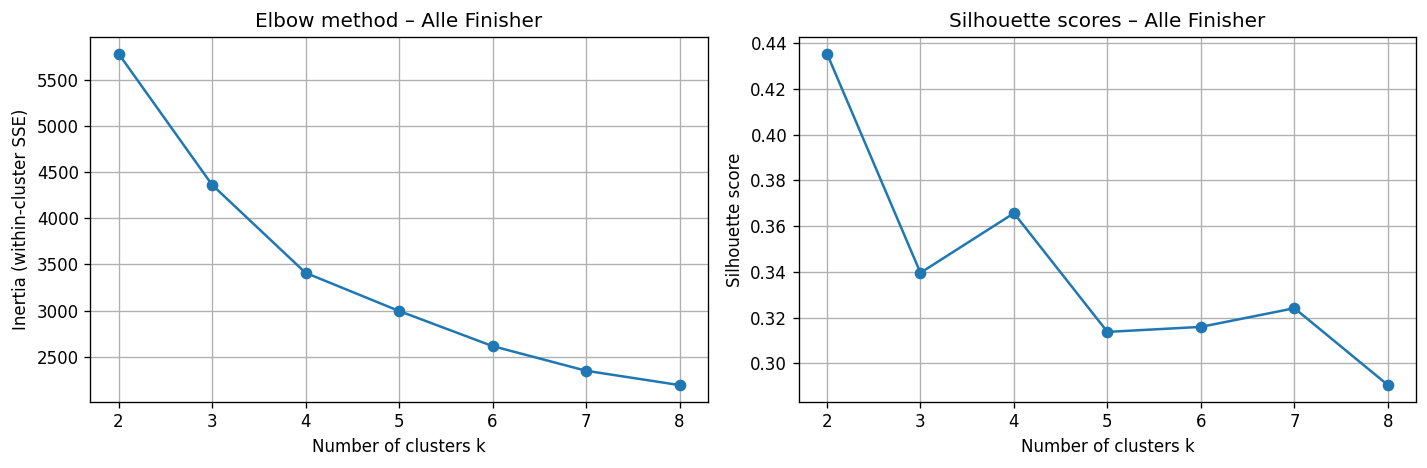

In [13]:
diag_all = cluster_diagnostics(
    X_clean,
    k_range=range(2, 9),
    random_state=42,
    title_suffix="Alle Finisher"
)


As you can see, the elbow seems to be at k = 5. The silhouette is higher at k = 4 compared to k =3 or k = 5. This indicates that albeit k = 5 has a lower inertia, the cluster overall seems to be less consistent meaning that a previously strong cluster in k = 4 has been disrupted.

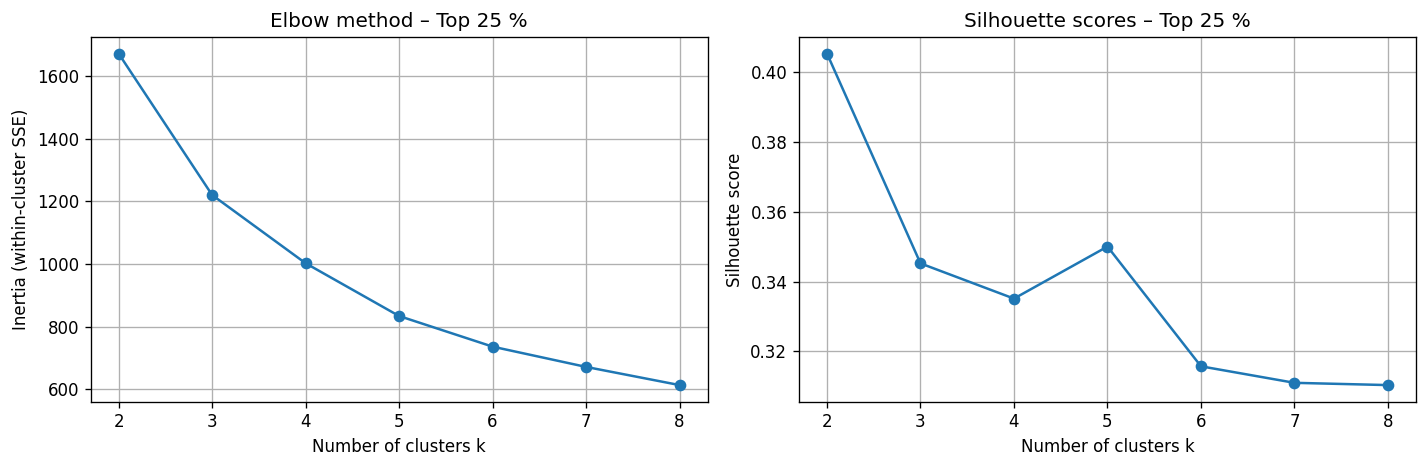

In [14]:
# Top 20 % based on overall time
top25_mask = finisher_rel["overall_rel"] >= 0.75
top25 = finisher_rel.loc[top25_mask].copy()

X_top25 = top25[["swim_rel", "bike_rel", "run_rel"]].copy()
X_top25 = X_top25.dropna()

diag_top25 = cluster_diagnostics(
    X_top25,
    k_range=range(2, 9),
    random_state=42,
    title_suffix="Top 25 %"
)


Based on the reasoning before, k = 5 make most sense considering silhouette score and elbow curve

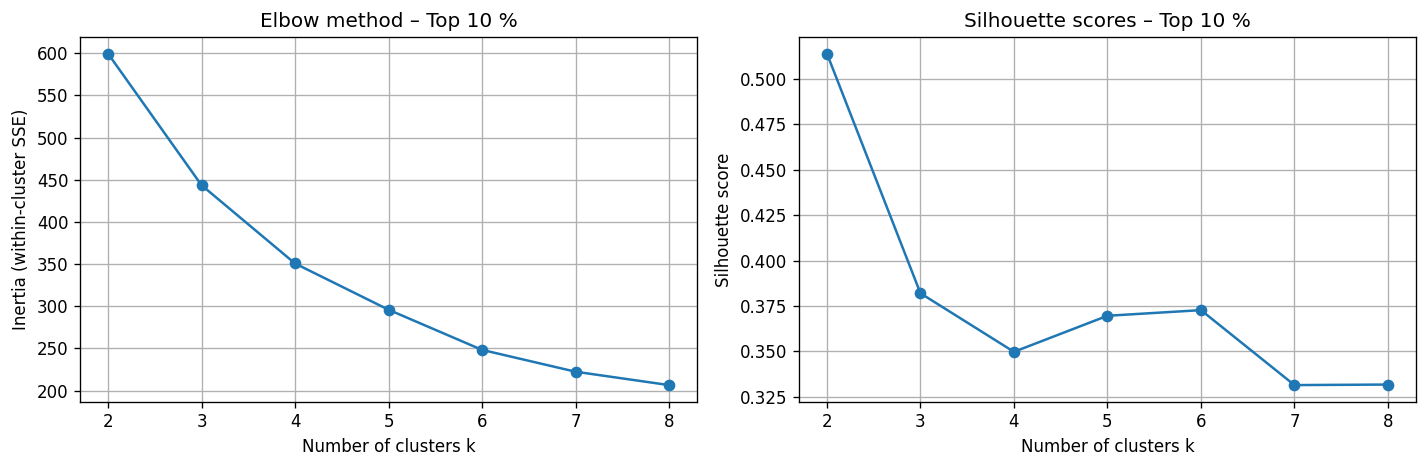

In [15]:
# Top 20 % based on overall time

top10_mask = finisher_rel["overall_rel"] >= 0.90
top10 = finisher_rel.loc[top10_mask].copy()

X_top10 = top10[["swim_rel", "bike_rel", "run_rel"]].copy()
X_top10 = X_top10.dropna()

diag_top10 = cluster_diagnostics(
    X_top10,
    k_range=range(2, 9),
    random_state=42,
    title_suffix="Top 10 %"
)


Again, k = 5 makes most sense.

## 6. Fitting K-Means & Defining Archetypes <a id="fit-kmeans"></a>

With k fixed, we now:

We now fit k-means on the full dataset using the chosen number of clusters.
Then we attach the cluster labels back to each athlete and compute 
cluster-level summaries that will form the basis for our archetypes.


## 6.1 Fitting K-Means & Defining Archetypes <a id="fit-kmeans"></a>

# fit k-means back to dataframe

In [ ]:
FEATURE_COLS = ["swim_rel", "bike_rel", "run_rel"]

# chosen values for k based on previous analysis
K_ALL = 4
K_TOP25 = 5
K_TOP10 = 5

In [17]:
mask_all = finisher_rel[FEATURE_COLS].notna().all(axis=1)

finisher_rel, kmeans_all = fit_kmeans_and_add_labels(
    finisher_rel,
    feature_cols=FEATURE_COLS,
    n_clusters=K_ALL,
    label_col="cluster_all",
    row_mask=mask_all,
)

finisher_rel[["swim_rel", "bike_rel", "run_rel", "cluster_all"]].head()

,swim_rel,bike_rel,run_rel,cluster_all
0,0.782313,0.709459,0.952703,1.0
1,0.871304,0.986159,0.968076,1.0
2,0.961304,0.989619,0.981450,1.0
3,0.994783,0.991349,0.987921,1.0
4,0.944348,0.979239,0.989646,1.0


In [ ]:
# now we do the same for top 25
mask_top25 = finisher_rel["overall_rel"] >= 0.75

finisher_rel, kmeans_top25 = fit_kmeans_and_add_labels(
    finisher_rel,
    feature_cols=FEATURE_COLS,
    n_clusters=K_TOP25,
    label_col="cluster_top25",
    row_mask=mask_top25,
)

finisher_rel[["overall_rel", "cluster_all", "cluster_top25"]].head()


,overall_rel,cluster_all,cluster_top25
0,0.925676,1.0,3.0
1,0.981034,1.0,1.0
2,0.987931,1.0,1.0
3,0.989655,1.0,1.0
4,0.986207,1.0,1.0


In [ ]:
# now we extend this to top 10
mask_top10 = finisher_rel["overall_rel"] >= 0.90

finisher_rel, kmeans_top10 = fit_kmeans_and_add_labels(
    finisher_rel,
    feature_cols=FEATURE_COLS,
    n_clusters=K_TOP10,
    label_col="cluster_top10",
    row_mask=mask_top10,
)

finisher_rel[["overall_rel", "cluster_all", "cluster_top25", "cluster_top10"]].head()


,overall_rel,cluster_all,cluster_top25,cluster_top10
0,0.925676,1.0,3.0,4.0
1,0.981034,1.0,1.0,4.0
2,0.987931,1.0,1.0,2.0
3,0.989655,1.0,1.0,2.0
4,0.986207,1.0,1.0,2.0


### 6.2 defining archetypes and assigning labels
#### I used chat gpt for generating the labels per archetype as well as the explanation



In [20]:
cluster_summary_all = make_cluster_summary(finisher_rel, "cluster_all")
cluster_summary_all



,cluster_all,n,mean_swim,mean_bike,mean_run,median_overall_rel,mean_overall_rel,share
0,0,764891,0.202375,0.188471,0.210141,0.155898,0.164720,0.287611
1,1,761397,0.799680,0.820625,0.808935,0.853627,0.845183,0.286297
2,2,543836,0.669732,0.433340,0.337565,0.416107,0.407486,0.204491
3,3,589342,0.340697,0.549596,0.625794,0.571859,0.572825,0.221602


Core archetypes – all athletes (cluster_all)

Strong All-Rounders – Above average in swim, bike, and run with the best overall results.

Swim-Strong Specialists – Strong swim, but weaker bike and especially run.

Run-Strong Chasers – Weaker swim, decent bike, strong run to make up ground late.

Developing Athletes – Below average in all three legs; lots of room to improve overall.

In [ ]:
cluster_name_map_all = {
    0: "Developing Athletes",
    1: "Strong All-Rounders",
    2: "Run-Strong Chasers",
    3: "Swim-Strong Specialists",
}

finisher_rel["archetype_all"] = (
    finisher_rel["cluster_all"]
    .dropna()
    .astype(int)
    .map(cluster_name_map_all)
)


In [22]:
cluster_summary_top25 = make_cluster_summary(finisher_rel, "cluster_top25")
cluster_summary_top25

,cluster_top25,n,mean_swim,mean_bike,mean_run,median_overall_rel,mean_overall_rel,share
0,0,73800,0.381517,0.799406,0.848154,0.808178,0.818529,0.111166
1,1,235966,0.912214,0.931712,0.930092,0.952446,0.948666,0.355440
2,2,107585,0.861314,0.854277,0.688016,0.823802,0.824861,0.162057
3,3,96091,0.824688,0.690614,0.847058,0.820847,0.822928,0.144743
4,4,150429,0.648287,0.844937,0.840040,0.855224,0.854119,0.226594


Refined archetypes – top 25% (cluster_top25)

Elite All-Rounders – Very strong in all three legs; top of the top 25%.

Bike–Run All-Rounders – Good swim, very strong bike and run.

Swim–Bike Specialists – Strong swim and bike, relatively weaker run.

On-Land Chasers – Weak swim, but strong bike and run in a fast field.

Swim–Run Specialists – Strong swim and run, weaker bike.

In [23]:
cluster_name_map_top25 = {
    0: "Bike–Run All-Rounders",
    1: "Swim–Bike Specialists",
    2: "Elite All-Rounders",
    3: "On-Land Chasers",
    4: "Swim–Run Specialists",
}

finisher_rel["archetype_top25"] = (
    finisher_rel["cluster_top25"]
    .dropna()
    .astype(int)
    .map(cluster_name_map_top25)
)


In [24]:
cluster_summary_top10 = make_cluster_summary(finisher_rel, "cluster_top10")
cluster_summary_top10

,cluster_top10,n,mean_swim,mean_bike,mean_run,median_overall_rel,mean_overall_rel,share
0,0,60533,0.937514,0.899449,0.876596,0.927393,0.928184,0.229084
1,1,31693,0.678289,0.919881,0.930103,0.928151,0.931780,0.119941
2,2,96189,0.958630,0.967291,0.968077,0.979592,0.977727,0.364023
3,3,9597,0.438641,0.922020,0.941228,0.923451,0.928152,0.036319
4,4,66227,0.830646,0.919882,0.932016,0.939292,0.939945,0.250633


Refined archetypes – top 10% (cluster_top10)

World-Class All-Rounders – Outstanding in all three legs; best overall performances.

Elite Bike–Run All-Rounders – Excellent bike and run, solid swim.

Swim–Run Elite – Excellent swim and run, slightly weaker bike.

Swim–Bike Elite – Strong swim and bike, weaker run.

On-Land Rockets – Mediocre swim, but exceptional bike and run.

In [25]:
cluster_name_map_top10 = {
    0: "Swim–Run",
    1: "Weak-Swim Land",
    2: "Bike–Run",
    3: "Elite All-Rounder",
    4: "Swim–Bike",
}


finisher_rel["archetype_top10"] = (
    finisher_rel["cluster_top10"]
    .dropna()
    .astype(int)
    .map(cluster_name_map_top10)
)


### 6.3 Assigning human-friendly archetype names

Based on the cluster summary (average relative swim/bike/run strength and overall performance),
we assign human-friendly names to each cluster

We then attach these names back to each athlete and reuse them in the later plots.



In [ ]:
### as before, we summarise everything for all, top 25, and top 10
cluster_summary_all = make_cluster_summary(finisher_rel, "cluster_all")


top25_mask = finisher_rel["overall_rel"] >= 0.75
cluster_summary_top25 = make_cluster_summary(finisher_rel[top25_mask], "cluster_top25")


top10_mask = finisher_rel["overall_rel"] >= 0.90
cluster_summary_top10 = make_cluster_summary(finisher_rel[top10_mask], "cluster_top10")

### 6.4 Radar plots for archetype profiles

To visualize the typical profile of each archetype, we use radar plots
with swim, bike, and run on the axes.

We create three sets of plots:

- for all athletes
- for the top 25%
- and for the top 10%

to see how archetype profiles change as performance increases.


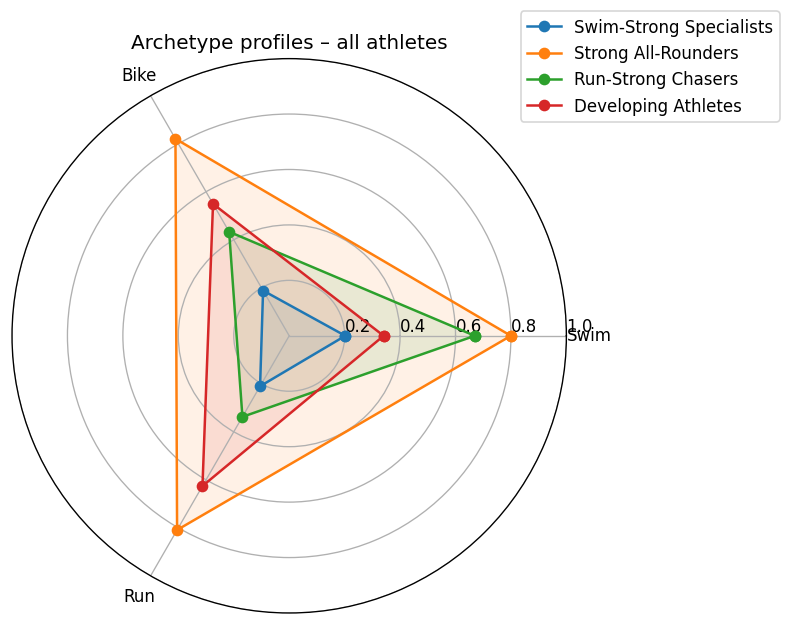

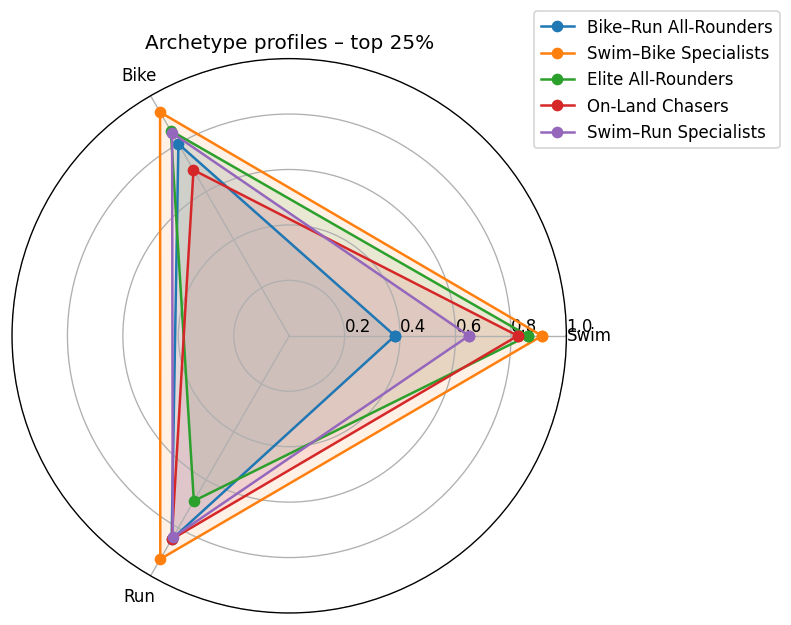

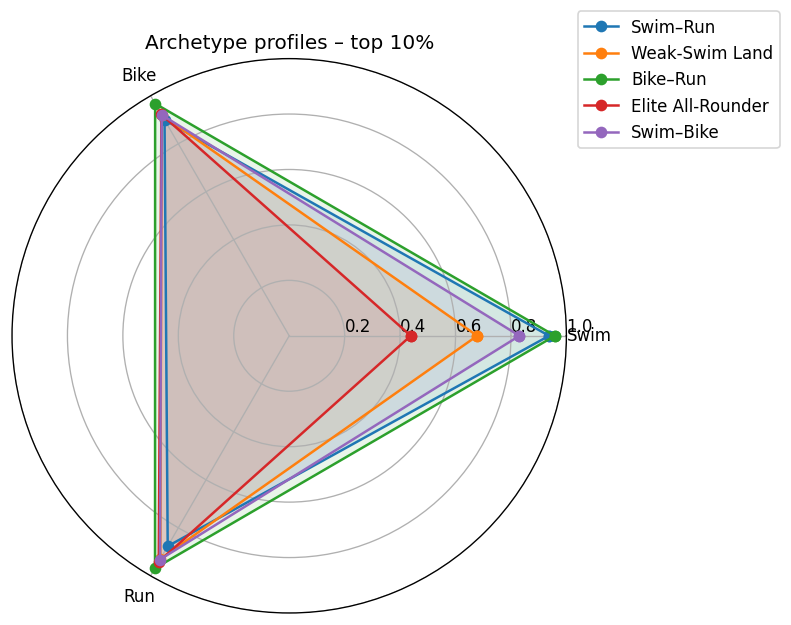

In [ ]:
### now we take the predefined function to create radar plots

plot_cluster_radar(
    cluster_summary_all,
    cluster_col="cluster_all",
    name_map=cluster_name_map_all,
    title="Archetype profiles – all athletes",
)

plot_cluster_radar(
    cluster_summary_top25,
    cluster_col="cluster_top25",
    name_map=cluster_name_map_top25,
    title="Archetype profiles – top 25%",
)

plot_cluster_radar(
    cluster_summary_top10,
    cluster_col="cluster_top10",
    name_map=cluster_name_map_top10,
    title="Archetype profiles – top 10%",
)


## 7. Are Generalists Actually Faster? <a id="generalists-faster"></a>

We now test the hypothesis that generalists are more successful.

Steps:

1. Use overall finish time to create performance deciles
   (top 10%, 10–20%, …, 90–100%).
2. For each cluster (archetype), compute:
   - median and IQR of overall time,
   - how often the archetype appears in each decile.
3. Visualize the distribution of archetypes by performance level.

If generalists are truly advantaged, we expect:

- A higher share of generalists in the fastest deciles.
- Clusters with big weaknesses to be under-represented among top finishers.


In [28]:
### only select athletes with a cluster

df_perf = finisher_rel.dropna(subset=["overall_rel", "cluster_all", "archetype_all"]).copy()

### create performance deciles

df_perf["performance_decile"] = pd.qcut(
    df_perf["overall_rel"],
    q=10,
    labels=range(1, 11)
).astype(int)

df_perf[["overall_rel", "performance_decile", "archetype_all"]].head()

,overall_rel,performance_decile,archetype_all
0,0.925676,10,Strong All-Rounders
1,0.981034,10,Strong All-Rounders
2,0.987931,10,Strong All-Rounders
3,0.989655,10,Strong All-Rounders
4,0.986207,10,Strong All-Rounders


In [29]:
# creating variables for readibility and convenience (no whitespace etc)
OVERALL_TIME_COL = "Overall Time (s)"
DISTANCE_COL = "distance"
GENDER_COL = "gender"

# start from df_perf (only rows with overall_rel + cluster/all labels)
group_cols = [DISTANCE_COL, GENDER_COL, "archetype_all"] ### since we consider the easiest case first

cluster_perf_by_dist_gender = (
    df_perf
    .groupby(group_cols)
    .agg(
        n=("overall_rel", "size"), # we have overall time as target
        median_time=(OVERALL_TIME_COL, "median"), # readible value of overall time
        q25_time=(OVERALL_TIME_COL, lambda x: x.quantile(0.25)), # readible value of 25th percentile
        q75_time=(OVERALL_TIME_COL, lambda x: x.quantile(0.75)), # readible value of 75th percentile
        median_overall_rel=("overall_rel", "median"),
        mean_overall_rel=("overall_rel", "mean"),
    )
    .reset_index()
)

cluster_perf_by_dist_gender["iqr_time"] = ( # now calculate the iqr which is 75th - 25th percentile to check how evenly results are spread out within an archetype
    cluster_perf_by_dist_gender["q75_time"]
    - cluster_perf_by_dist_gender["q25_time"]
)

# now convert previously converted datetime from seconds back to datetime (I am sure there must be an easier and smarter way)
cluster_perf_by_dist_gender["median_td"] = pd.to_timedelta(
    cluster_perf_by_dist_gender["median_time"], unit="s"
)
cluster_perf_by_dist_gender["q25_td"] = pd.to_timedelta(
    cluster_perf_by_dist_gender["q25_time"], unit="s"
)
cluster_perf_by_dist_gender["q75_td"] = pd.to_timedelta(
    cluster_perf_by_dist_gender["q75_time"], unit="s"
)

def td_to_hms(td):
    if pd.isna(td):
        return None
    total_seconds = int(td.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:d}:{minutes:02d}:{seconds:02d}"

cluster_perf_by_dist_gender["median_time_hms"] = cluster_perf_by_dist_gender["median_td"].apply(td_to_hms)
cluster_perf_by_dist_gender["q25_time_hms"]    = cluster_perf_by_dist_gender["q25_td"].apply(td_to_hms)
cluster_perf_by_dist_gender["q75_time_hms"]    = cluster_perf_by_dist_gender["q75_td"].apply(td_to_hms)


cluster_perf_by_dist_gender = cluster_perf_by_dist_gender.drop(
    columns=["median_td", "q25_td", "q75_td"]
)

cluster_perf_by_dist_gender[[
    "distance", "gender", "archetype_all",
    "median_time_hms", "q25_time_hms", "q75_time_hms",
    "median_overall_rel"
]]



,distance,gender,archetype_all,median_time_hms,q25_time_hms,q75_time_hms,median_overall_rel
0,70.3,Female,Developing Athletes,6:08:41,5:51:08,6:27:08,0.569378
1,70.3,Female,Run-Strong Chasers,6:29:57,6:10:16,6:52:07,0.421260
2,70.3,Female,Strong All-Rounders,5:24:37,5:05:30,5:42:52,0.853392
3,70.3,Female,Swim-Strong Specialists,7:17:41,6:53:15,7:44:51,0.155172
4,70.3,Male,Developing Athletes,5:40:21,5:22:55,5:59:02,0.569145
5,70.3,Male,Run-Strong Chasers,6:00:35,5:40:32,6:24:46,0.417994
6,70.3,Male,Strong All-Rounders,4:58:48,4:41:39,5:16:55,0.853333
7,70.3,Male,Swim-Strong Specialists,6:48:05,6:21:21,7:19:36,0.155499
8,full-distance,Female,Developing Athletes,12:54:49,12:12:26,13:37:17,0.576923
9,full-distance,Female,Run-Strong Chasers,13:47:10,12:58:58,14:34:55,0.410423


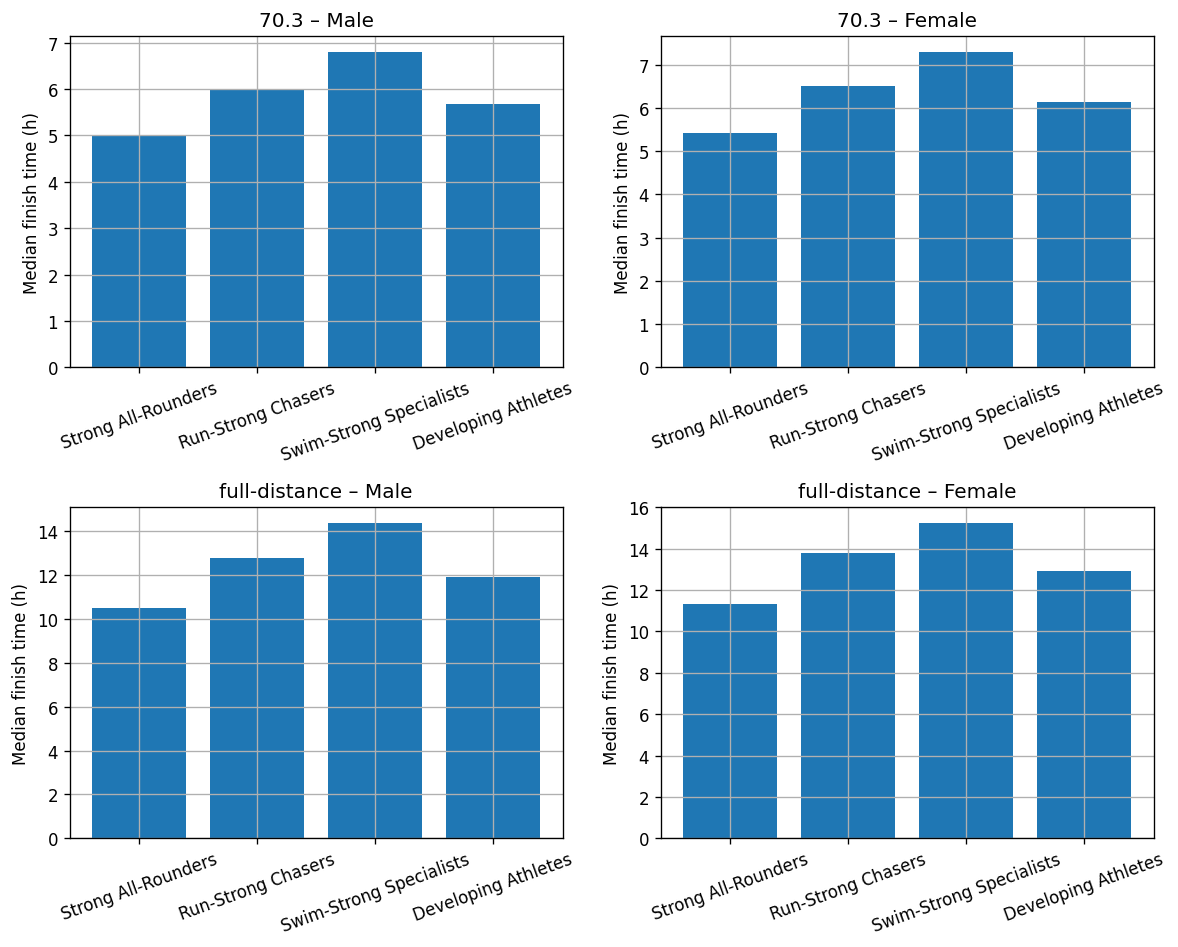

In [30]:
### now plot the data
### approach is pretty straightforward
### however, the axes must not be shared since we consider different races and genders
### we could use relevant times but actual times are more readible for most people

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

distances = ["70.3", "full-distance"]
genders = ["Male", "Female"]
archetype_order = [
    "Strong All-Rounders",
    "Run-Strong Chasers",
    "Swim-Strong Specialists",
    "Developing Athletes",
]

for i, dist in enumerate(distances):
    for j, gender in enumerate(genders):
        ax = axes[i, j]

        subset = cluster_perf_by_dist_gender[
            (cluster_perf_by_dist_gender["distance"] == dist)
            & (cluster_perf_by_dist_gender["gender"] == gender)
        ].copy()

        subset["archetype_all"] = pd.Categorical(
            subset["archetype_all"],
            categories=archetype_order,
            ordered=True,
        )
        subset = subset.sort_values("archetype_all")

        ax.bar(
            subset["archetype_all"],
            subset["median_time"] / 3600.0,  # hours indicating time (hh:mm:ss would overcrowd plot)
        )

        ax.set_title(f"{dist} – {gender}")
        ax.set_ylabel("Median finish time (h)")
        ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()


In [31]:
# now we do exactly the same for the top 10

top10_mask = df_perf["overall_rel"] >= 0.90
df_top10 = df_perf[top10_mask].copy()

df_top10[["overall_rel", "archetype_top10"]].head()

,overall_rel,archetype_top10
0,0.925676,Swim–Bike
1,0.981034,Swim–Bike
2,0.987931,Bike–Run
3,0.989655,Bike–Run
4,0.986207,Bike–Run


In [32]:
OVERALL_TIME_COL = "Overall Time (s)"
DISTANCE_COL = "distance"
GENDER_COL = "gender"

group_cols = [DISTANCE_COL, GENDER_COL, "archetype_top10"]

cluster_top10_by_dist_gender = (
    df_top10
    .groupby(group_cols)
    .agg(
        n=("overall_rel", "size"),
        median_time=(OVERALL_TIME_COL, "median"),
        q25_time=(OVERALL_TIME_COL, lambda x: x.quantile(0.25)),
        q75_time=(OVERALL_TIME_COL, lambda x: x.quantile(0.75)),
        median_overall_rel=("overall_rel", "median"),
        mean_overall_rel=("overall_rel", "mean"),
    )
    .reset_index()
)

cluster_top10_by_dist_gender["iqr_time"] = (
    cluster_top10_by_dist_gender["q75_time"]
    - cluster_top10_by_dist_gender["q25_time"]
)

cluster_top10_by_dist_gender.head()


,distance,gender,archetype_top10,n,median_time,q25_time,q75_time,median_overall_rel,mean_overall_rel,iqr_time
0,70.3,Female,Bike–Run,14834,16893.5,16154.0,17617.0,0.978221,0.976174,1463.0
1,70.3,Female,Elite All-Rounder,1322,18766.5,18120.5,19394.0,0.923222,0.928895,1273.5
2,70.3,Female,Swim–Bike,9887,18227.0,17607.0,18850.5,0.938697,0.939699,1243.5
3,70.3,Female,Swim–Run,9170,18518.0,17930.0,19105.0,0.926543,0.927686,1175.0
4,70.3,Female,Weak-Swim Land,4773,18574.0,17975.0,19155.0,0.927885,0.931374,1180.0


In [33]:
def seconds_to_hms(seconds):
    if pd.isna(seconds):
        return None
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours:d}:{minutes:02d}:{secs:02d}"

cluster_top10_by_dist_gender["median_time_hms"] = cluster_top10_by_dist_gender["median_time"].apply(seconds_to_hms)
cluster_top10_by_dist_gender["q25_time_hms"]    = cluster_top10_by_dist_gender["q25_time"].apply(seconds_to_hms)
cluster_top10_by_dist_gender["q75_time_hms"]    = cluster_top10_by_dist_gender["q75_time"].apply(seconds_to_hms)

cluster_top10_by_dist_gender[
    ["distance", "gender", "archetype_top10",
     "median_time_hms", "q25_time_hms", "q75_time_hms",
     "median_overall_rel", "n"]
]


,distance,gender,archetype_top10,median_time_hms,q25_time_hms,q75_time_hms,median_overall_rel,n
0,70.3,Female,Bike–Run,4:41:33,4:29:14,4:53:37,0.978221,14834
1,70.3,Female,Elite All-Rounder,5:12:46,5:02:00,5:23:14,0.923222,1322
2,70.3,Female,Swim–Bike,5:03:47,4:53:27,5:14:10,0.938697,9887
3,70.3,Female,Swim–Run,5:08:38,4:58:50,5:18:25,0.926543,9170
4,70.3,Female,Weak-Swim Land,5:09:34,4:59:35,5:19:15,0.927885,4773
5,70.3,Male,Bike–Run,4:21:28,4:08:54,4:32:45,0.979292,49140
6,70.3,Male,Elite All-Rounder,4:47:27,4:38:08,4:58:00,0.921980,3847
7,70.3,Male,Swim–Bike,4:41:23,4:31:42,4:51:37,0.937669,31621
8,70.3,Male,Swim–Run,4:44:29,4:35:15,4:54:10,0.927319,30012
9,70.3,Male,Weak-Swim Land,4:45:33,4:35:44,4:55:11,0.926199,13695


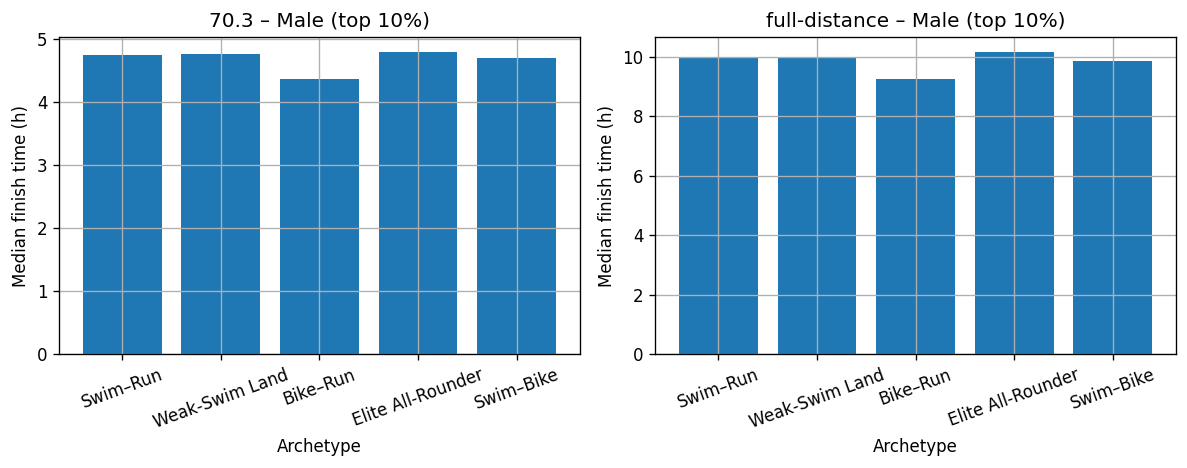

In [34]:
distances = ["70.3", "full-distance"]
gender = "Male"

archetype_order_top10 = [
    "Swim–Run",
    "Weak-Swim Land",
    "Bike–Run",
    "Elite All-Rounder",
    "Swim–Bike",
]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, dist in enumerate(distances):
    ax = axes[i]

    subset = cluster_top10_by_dist_gender[
        (cluster_top10_by_dist_gender["distance"] == dist)
        & (cluster_top10_by_dist_gender["gender"] == gender)
    ].copy()

    if subset.empty:
        ax.set_visible(False)
        continue

    subset["archetype_top10"] = pd.Categorical(
        subset["archetype_top10"],
        categories=archetype_order_top10,
        ordered=True,
    )
    subset = subset.sort_values("archetype_top10")

    ax.bar(
        subset["archetype_top10"],
        subset["median_time"] / 3600.0,
    )

    # again we use autoscaling and trust matplotlib
    ax.relim()
    ax.autoscale_view()

    ax.set_title(f"{dist} – {gender} (top 10%)")
    ax.set_xlabel("Archetype")
    ax.set_ylabel("Median finish time (h)")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()


## 8. How Better Athletes Become More “Generalist” <a id="progression-generalist"></a>

Beyond cluster averages, we want to know:  
Do individual athletes become more balanced across disciplines as they get faster?

To measure this:

1. For each athlete, we compute z-scores of swim, bike, and run performance.
2. We then calculate the variance of these three z-scores:
   - high variance → pronounced strengths and weaknesses → specialist.
   - low variance → similar performance across legs → generalist.
3. We relate this specialization variance to performance deciles.

If the “generalist hypothesis” holds, we should see:

- Higher variance among slower athletes,
- Lower variance among faster athletes.


In [35]:
# just as before
# drop.na (not sure if actually needed but I would rather too often than not often enough)
# select relevant features
df_perf = finisher_rel.dropna(
    subset=["overall_rel", "swim_rel", "bike_rel", "run_rel"]
).copy()

# now add performance decile (this is obviously an opinionated choice)
if "performance_decile" not in df_perf.columns:
    df_perf["performance_decile"] = pd.qcut(
        df_perf["overall_rel"],
        q=10,
        labels=range(1, 11)
    ).astype(int)

# compute global means and std by leg
leg_cols = ["swim_rel", "bike_rel", "run_rel"]

means = df_perf[leg_cols].mean()
stds  = df_perf[leg_cols].std()

means, stds


(swim_rel    0.499604
 bike_rel    0.499554
 run_rel     0.499740
 dtype: float64,
 swim_rel    0.288607
 bike_rel    0.288572
 run_rel     0.288480
 dtype: float64)

In [36]:
# now calculate z-score by leg
for col in leg_cols:
    z_col = col.replace("_rel", "_z")
    df_perf[z_col] = (df_perf[col] - means[col]) / stds[col]

df_perf[["swim_rel", "swim_z", "bike_rel", "bike_z", "run_rel", "run_z"]].head()


,swim_rel,swim_z,bike_rel,bike_z,run_rel,run_z
0,0.782313,0.979563,0.709459,0.727395,0.952703,1.570169
1,0.871304,1.287911,0.986159,1.686254,0.968076,1.623459
2,0.961304,1.599753,0.989619,1.698245,0.981450,1.669818
3,0.994783,1.715753,0.991349,1.704240,0.987921,1.692250
4,0.944348,1.541000,0.979239,1.662272,0.989646,1.698232


In [37]:
z_cols = ["swim_z", "bike_z", "run_z"]

df_perf["z_variance"] = df_perf[z_cols].var(axis=1, ddof=0)

df_perf[["overall_rel", "performance_decile", "z_variance"]].head()


,overall_rel,performance_decile,z_variance
0,0.925676,10,0.124741
1,0.981034,10,0.030579
2,0.987931,10,0.001713
3,0.989655,10,0.000092
4,0.986207,10,0.004525


In [38]:
# variance by decile is necessary since we expect variance to drop with increasing performance
# variance may also drop for developing athletes since they have potential for improvement in all areas

var_by_decile = (
    df_perf
    .groupby("performance_decile")["z_variance"]
    .agg(
        median_var="median",
        q25_var=lambda x: x.quantile(0.25),
        q75_var=lambda x: x.quantile(0.75),
        mean_var="mean",
    )
    .reset_index()
)

var_by_decile


,performance_decile,median_var,q25_var,q75_var,mean_var
0,1,0.056719,0.016535,0.182404,0.176187
1,2,0.135658,0.052715,0.326570,0.260142
2,3,0.193422,0.079237,0.408868,0.304356
3,4,0.231967,0.097186,0.459245,0.328493
4,5,0.245993,0.103562,0.475124,0.331768
5,6,0.238840,0.100494,0.463562,0.321784
6,7,0.208838,0.086504,0.413008,0.294351
7,8,0.158840,0.064457,0.330324,0.248858
8,9,0.089996,0.034574,0.211053,0.176637
9,10,0.017252,0.003791,0.060255,0.068814


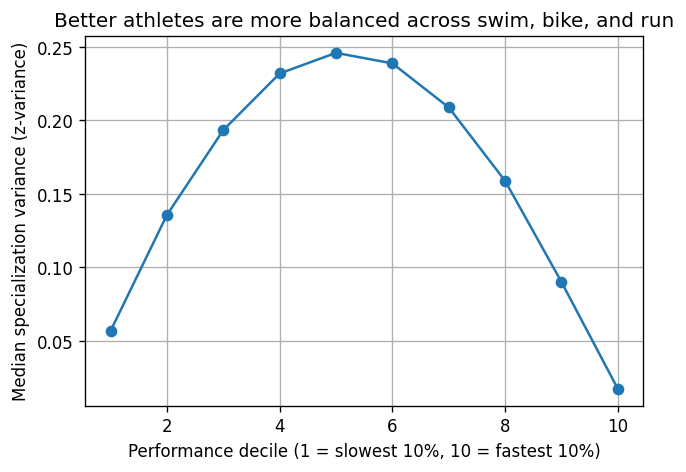

In [39]:
# this plot may quickly look overcrowded but this chart will be used in an article and I want people to understand

plt.figure(figsize=(6, 4))
plt.plot(
    var_by_decile["performance_decile"],
    var_by_decile["median_var"],
    marker="o",
)
plt.xlabel("Performance decile (1 = slowest 10%, 10 = fastest 10%)")
plt.ylabel("Median specialization variance (z-variance)")
plt.title("Better athletes are more balanced across swim, bike, and run")
plt.grid(True)
plt.show()


In [40]:
# now calculate pairwise gaps to support my hypothesis
df_perf["gap_bike_run"] = (df_perf["bike_z"] - df_perf["run_z"]).abs()
df_perf["gap_swim_bike"] = (df_perf["swim_z"] - df_perf["bike_z"]).abs()
df_perf["gap_swim_run"]  = (df_perf["swim_z"] - df_perf["run_z"]).abs()

# here we check the swim vs land disciplines hypothesis
df_perf["gap_swim_land"] = (
    df_perf["gap_swim_bike"] + df_perf["gap_swim_run"]
) / 2.0


In [41]:
gaps_by_decile = (
    df_perf
    .groupby("performance_decile")[["gap_bike_run", "gap_swim_land"]]
    .median()
    .reset_index()
)

gaps_by_decile


,performance_decile,gap_bike_run,gap_swim_land
0,1,0.236487,0.364704
1,2,0.446383,0.564633
2,3,0.553496,0.678971
3,4,0.613012,0.743807
4,5,0.626085,0.767270
5,6,0.606316,0.759793
6,7,0.551902,0.709091
7,8,0.461666,0.621904
8,9,0.324410,0.470666
9,10,0.113627,0.208905


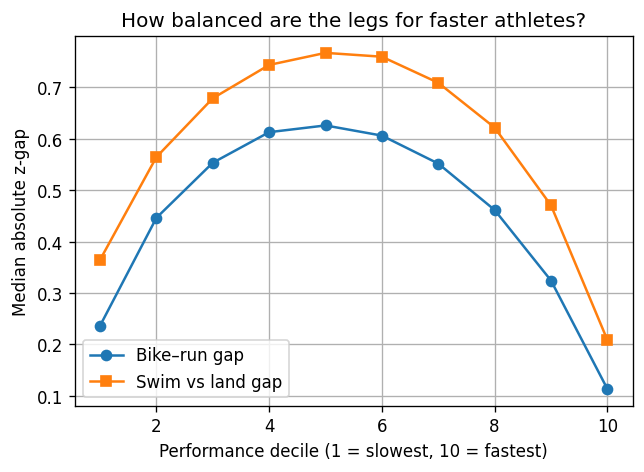

In [42]:
# again, pretty much same plot as before
plt.figure(figsize=(6, 4))
plt.plot(
    gaps_by_decile["performance_decile"],
    gaps_by_decile["gap_bike_run"],
    marker="o",
    label="Bike–run gap",
)
plt.plot(
    gaps_by_decile["performance_decile"],
    gaps_by_decile["gap_swim_land"],
    marker="s",
    label="Swim vs land gap",
)
plt.xlabel("Performance decile (1 = slowest, 10 = fastest)")
plt.ylabel("Median absolute z-gap")
plt.title("How balanced are the legs for faster athletes?")
plt.legend()
plt.grid(True)
plt.show()
